##Libraries

In [ ]:
# Install required packages
!pip install roboflow
!pip install monai
!pip install segment-geospatial
!pip install pycocotools

In [ ]:
# Import necessary libraries
from roboflow import Roboflow
import os
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from torch.utils.data import Dataset, DataLoader
from transformers import SamModel, SamProcessor
import leafmap
import monai
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast
from torch.optim import Adam

## Download dataset

In [ ]:
rf = Roboflow(api_key="5nAESdZUJDBa6zqZaEpG")
project = rf.workspace("satellite-iteka").project("merged-nyakw")
version = project.version(3)
dataset = version.download("coco-segmentation")

loading Roboflow workspace...
loading Roboflow project...


##Load Image and Polygon

loading annotations into memory...
Done (t=0.17s)
creating index...
index created!


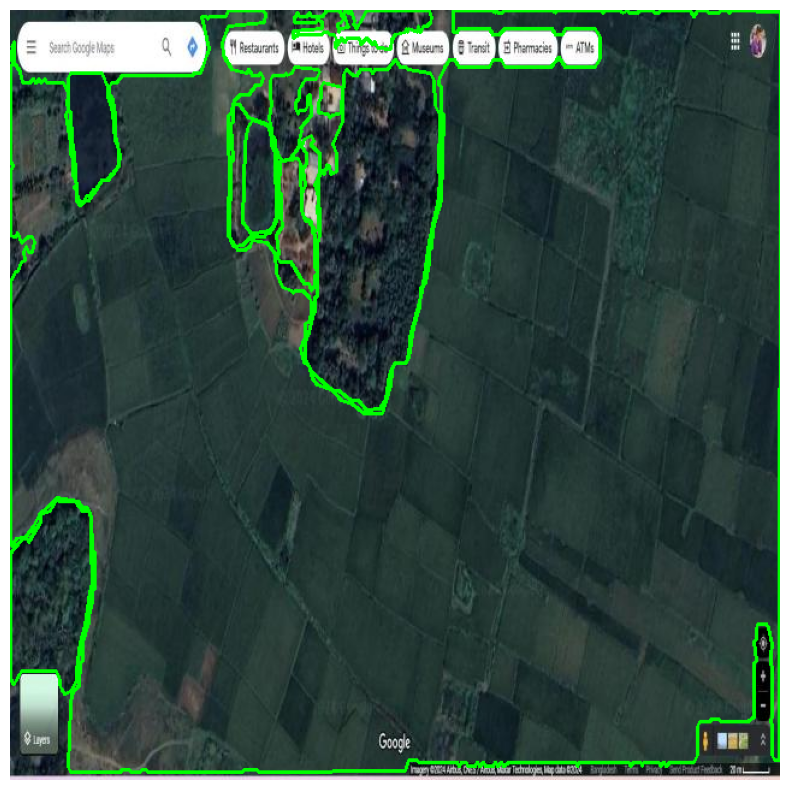

In [ ]:
# Define dataset paths
train_images_path = '/content/Merged-3/train/'
train_annotations_path = '/content/Merged-3/train/_annotations.coco.json'

# Load COCO annotations
coco = COCO(train_annotations_path)

# Get all image IDs
image_ids = coco.getImgIds()

# Initialize the SAM processor and model
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")
model = SamModel.from_pretrained("facebook/sam-vit-base")

# Move the model to the correct device
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Function to visualize images and polygon annotations
def display_image_and_polygons(coco, image_id):
    image_info = coco.loadImgs(image_id)[0]
    image_path = os.path.join(train_images_path, image_info['file_name'])
    image = cv2.imread(image_path)

    # Load annotations for the image
    annotation_ids = coco.getAnnIds(imgIds=image_id)
    annotations = coco.loadAnns(annotation_ids)

    # Draw polygon annotations
    for ann in annotations:
        segmentation = ann['segmentation']
        for seg in segmentation:
            poly_points = np.array(seg).reshape((-1, 2))
            cv2.polylines(image, [np.int32(poly_points)], isClosed=True, color=(0, 255, 0), thickness=2)

    # Show the image with the polygons
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# Example to display the first image with polygon annotations
display_image_and_polygons(coco, image_ids[0])

# Function to load image and polygons
def load_image_and_polygons(image_id, coco):
    # Load image metadata and path
    image_info = coco.loadImgs(image_id)[0]
    image_path = os.path.join(train_images_path, image_info['file_name'])
    image = cv2.imread(image_path)

    # Resize image to a smaller size if necessary
    image = cv2.resize(image, (256, 256))

    # Load polygons (annotations) for the image
    ann_ids = coco.getAnnIds(imgIds=image_id)
    annotations = coco.loadAnns(ann_ids)

    polygons = []
    for ann in annotations:
        for seg in ann['segmentation']:
            polygons.append(np.array(seg).reshape(-1, 2))

    return image, polygons

##SAM Dataset

In [ ]:
class SAMDataset(Dataset):
    def __init__(self, coco, processor):
        self.coco = coco
        self.image_ids = coco.getImgIds()
        self.processor = processor

    def __len__(self):
        return len(self.image_ids)

    def polygon_to_bounding_box(self, polygon):
        xs = [point[0] for point in polygon]
        ys = [point[1] for point in polygon]
        return [min(xs), min(ys), max(xs), max(ys)]

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image, polygons = load_image_and_polygons(image_id, self.coco)

        # Create bounding boxes from polygons
        bounding_boxes = []
        for polygon in polygons:
            if len(polygon) > 0:
                bbox = self.polygon_to_bounding_box(polygon)
                bounding_boxes.append(bbox)

        # Convert bounding_boxes to tensor and add batch dimension
        if bounding_boxes:  # Check if there are any bounding boxes
            input_boxes = torch.tensor(bounding_boxes, dtype=torch.float32)  # Convert to tensor
        else:
            input_boxes = torch.empty((0, 4), dtype=torch.float32)  # Create an empty tensor for no bounding boxes

        # Ensure the input_boxes have batch dimension
        input_boxes = input_boxes.unsqueeze(0)  # Shape: [1, nb_boxes, 4] - Wrap in batch dimension

        # Process the image and input boxes
        inputs = self.processor(image, input_boxes=input_boxes, return_tensors="pt")

        # Create ground truth masks from polygons (assuming binary masks)
        mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.float32)  # Create empty mask
        for polygon in polygons:
            cv2.fillPoly(mask, [polygon.astype(np.int32)], 1)  # Fill polygon areas with 1

        # Ensure masks are converted to tensor
        inputs['ground_truth_mask'] = torch.tensor(mask).unsqueeze(0)  # Add a channel dimension

        # Ensure the tensors are correctly shaped
        inputs = {k: v.squeeze(0) if v.ndim > 0 else v for k, v in inputs.items()}

        return inputs


def collate_fn(batch):
    pixel_values = torch.stack([item['pixel_values'] for item in batch])  # Stack pixel values
    ground_truth_masks = torch.stack([item['ground_truth_mask'] for item in batch])  # Stack ground truth masks

    # Handle input boxes: concatenate them while maintaining the batch structure
    input_boxes = []
    for item in batch:
        boxes = item['input_boxes']  # Get the input boxes for each item
        if boxes.shape[0] > 0:
            input_boxes.append(boxes)
        else:
            # Add an empty box if there are no bounding boxes
            input_boxes.append(torch.empty((0, 4), dtype=torch.float32))

    # Stack input boxes into a tensor while maintaining the batch dimension
    input_boxes = torch.cat([box.unsqueeze(0) for box in input_boxes], dim=0)  # Shape: [batch_size, nb_boxes, 4]

    return {
        'pixel_values': pixel_values,
        'input_boxes': input_boxes,
        'ground_truth_mask': ground_truth_masks,
    }

In [ ]:
# Initialize the dataset and dataloader
train_dataset = SAMDataset(coco=coco, processor=processor)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)

##Train

In [ ]:
# Training the Model
optimizer = Adam(model.parameters(), lr=1e-5)
loss_fn = monai.losses.DiceCELoss(sigmoid=True)
scaler = GradScaler()

num_epochs = 1
accumulation_steps = 2  # Reduce accumulation steps if needed

In [ ]:
import torch.nn.functional as F

# Ensure to resize ground truth masks to the shape of predicted masks
def resize_ground_truth(ground_truth_masks, target_size):
    # Resize the ground truth masks, maintaining the number of channels
    resized_masks = F.interpolate(ground_truth_masks, size=target_size, mode='bilinear', align_corners=False)
    return resized_masks

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for batch_idx, batch in enumerate(train_dataloader):
        optimizer.zero_grad()

        with autocast():
            pixel_values = batch['pixel_values'].to(device)
            input_boxes = batch['input_boxes'].to(device)
            ground_truth_masks = batch['ground_truth_mask'].unsqueeze(1).float().to(device)  # Ensure it's float and add a channel

            # Forward pass
            outputs = model(pixel_values=pixel_values, input_boxes=input_boxes)

            # Compute the loss
            predicted_masks = outputs.pred_masks  # Shape: [1, 50, 3, 256, 256]

            # Print shapes for debugging
            print(f"Predicted masks shape: {predicted_masks.shape}")
            print(f"Ground truth masks shape before resize: {ground_truth_masks.shape}")

            # Resize the ground truth masks to match predicted masks shape
            resized_ground_truth_masks = resize_ground_truth(ground_truth_masks, predicted_masks.shape[3:])  # Resize to (256, 256)

            # Print shape after resizing for debugging
            print(f"Resized ground truth masks shape: {resized_ground_truth_masks.shape}")

            # Ensure the ground truth masks have 50 masks like the predicted masks
            if resized_ground_truth_masks.shape[1] != predicted_masks.shape[1]:  # Check the number of masks
                resized_ground_truth_masks = resized_ground_truth_masks.repeat(1, predicted_masks.shape[1], 1, 1, 1)  # Repeat for the number of masks

            # Ensure the ground truth masks have 3 channels, like the predicted masks
            if resized_ground_truth_masks.shape[2] != predicted_masks.shape[2]:  # Check the channel dimension
                resized_ground_truth_masks = resized_ground_truth_masks.repeat(1, 1, predicted_masks.shape[2], 1, 1)  # Repeat for channel dimension

            # Now both tensors should have the same shape
            print(f"Final ground truth masks shape: {resized_ground_truth_masks.shape}")

            # Compute the loss
            loss = loss_fn(predicted_masks, resized_ground_truth_masks)

        loss = loss / accumulation_steps  # Normalize the loss by the accumulation steps
        scaler.scale(loss).backward()  # Backpropagation

        if (batch_idx + 1) % accumulation_steps == 0:
            scaler.step(optimizer)  # Update weights
            scaler.update()  # Update the scaler
            optimizer.zero_grad()  # Zero gradients after update

        running_loss += loss.item()

    # Calculate average loss for the epoch
    avg_loss = running_loss / len(train_dataloader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss}")

Predicted masks shape: torch.Size([1, 88, 3, 256, 256])
Ground truth masks shape before resize: torch.Size([1, 1, 256, 256])
Resized ground truth masks shape: torch.Size([1, 1, 256, 256])
Final ground truth masks shape: torch.Size([1, 88, 3, 256, 256])
Predicted masks shape: torch.Size([1, 12, 3, 256, 256])
Ground truth masks shape before resize: torch.Size([1, 1, 256, 256])
Resized ground truth masks shape: torch.Size([1, 1, 256, 256])
Final ground truth masks shape: torch.Size([1, 12, 3, 256, 256])
Predicted masks shape: torch.Size([1, 38, 3, 256, 256])
Ground truth masks shape before resize: torch.Size([1, 1, 256, 256])
Resized ground truth masks shape: torch.Size([1, 1, 256, 256])
Final ground truth masks shape: torch.Size([1, 38, 3, 256, 256])
Predicted masks shape: torch.Size([1, 78, 3, 256, 256])
Ground truth masks shape before resize: torch.Size([1, 1, 256, 256])
Resized ground truth masks shape: torch.Size([1, 1, 256, 256])
Final ground truth masks shape: torch.Size([1, 78, 3,

OutOfMemoryError: CUDA out of memory. Tried to allocate 420.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 67.06 MiB is free. Process 103631 has 14.68 GiB memory in use. Of the allocated memory 13.81 GiB is allocated by PyTorch, and 748.48 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)